## PPO

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
import time
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict, Optional, Union, Tuple
from flax.training.train_state import TrainState
import distrax
import gymnax
import functools
from functools import partial
from gymnax.environments import environment, spaces
import chex
import wandb
from flax import struct


class GymnaxWrapper(object):
    """Base class for Gymnax wrappers."""

    def __init__(self, env):
        self._env = env
    
    # provide proxy access to regular attributes of wrapped object
    def __getattr__(self, name):
        return getattr(self._env, name)

@struct.dataclass
class LogEnvState:
    env_state: environment.EnvState
    episode_returns: float
    episode_lengths: int
    returned_episode_returns: float
    returned_episode_lengths: int
    timestep: int

class LogWrapper(GymnaxWrapper):
    """Log the episode returns and lengths."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, env_state = self._env.reset(key, params)
        state = LogEnvState(env_state, 0, 0, 0, 0, 0)
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, env_state, reward, done, info = self._env.step(key, state.env_state, action, params)
        new_episode_return = state.episode_returns + reward
        new_episode_length = state.episode_lengths + 1
        state = LogEnvState(
            env_state = env_state,
            episode_returns = new_episode_return * (1 - done),
            episode_lengths = new_episode_length * (1 - done),
            returned_episode_returns = state.returned_episode_returns * (1 - done) + new_episode_return * done,
            returned_episode_lengths = state.returned_episode_lengths * (1 - done) + new_episode_length * done,
            timestep = state.timestep + 1,
        )
        info["returned_episode"] = done
        info["return_info"] = jnp.stack([state.timestep, state.returned_episode_returns])
        return obs, state, reward, done, info

class ScannedRNN(nn.Module):

  @functools.partial(
    nn.scan,
    variable_broadcast='params',
    in_axes=0,
    out_axes=0,
    split_rngs={'params': False})
  @nn.compact
  def __call__(self, carry, x):
    """Applies the module."""
    features = carry[0].shape[-1]
    rnn_state = carry
    ins, resets = x
    rnn_state = jnp.where(resets[:, np.newaxis], self.initialize_carry(ins.shape[0], ins.shape[1]), rnn_state)
    new_rnn_state, y = nn.GRUCell(features)(rnn_state, ins)
    return new_rnn_state, y

  @staticmethod
  def initialize_carry(batch_size, hidden_size):
    return nn.GRUCell(hidden_size, parent=None).initialize_carry(
        jax.random.PRNGKey(0), (batch_size, hidden_size))

class ActorCriticRNN(nn.Module):
    action_dim: Sequence[int]
    config: Dict

    @nn.compact
    def __call__(self, hidden, x):
        obs, dones = x
        embedding = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(obs)
        embedding = nn.leaky_relu(embedding)
        embedding = nn.Dense(256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(embedding)
        embedding = nn.leaky_relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        actor_mean = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(embedding)
        actor_mean = nn.leaky_relu(actor_mean)
        actor_mean = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(actor_mean)
        actor_mean = nn.leaky_relu(actor_mean)
        actor_mean = nn.Dense(self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0))(actor_mean)
        if self.config["CONTINUOUS"]:
            actor_logtstd = self.param('log_std', nn.initializers.zeros, (self.action_dim,))
            pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))
        else:
            pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(embedding)
        critic = nn.leaky_relu(critic)
        critic = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(critic)
        critic = nn.leaky_relu(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(critic)

        return hidden, pi, jnp.squeeze(critic, axis=-1)

    @staticmethod
    def initialize_carry(batch_size, hidden_size):
        return nn.GRUCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (batch_size, hidden_size))

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    if "ENV_NAME" not in config:
        env, env_params = config["ENV"], config["ENV_PARAMS"]
        env = LogWrapper(env)
    else:
        env, env_params = gymnax.make(config["ENV_NAME"])
        env = LogWrapper(env)

    if "MOD_ENV_PARAMS" in config:
        env_params = env_params.replace(**config["MOD_ENV_PARAMS"])

    config["CONTINUOUS"] = type(env.action_space(env_params)) == spaces.Box 

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        if config["CONTINUOUS"]:
            network = ActorCriticRNN(env.action_space(env_params).shape[0], config=config)
        else:
            network = ActorCriticRNN(env.action_space(env_params).n, config=config)
        rng, _rng = jax.random.split(rng)
        init_x = (jnp.zeros((1, config["NUM_ENVS"], *env.observation_space(env_params).shape)), jnp.zeros((1, config["NUM_ENVS"])))
        init_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], 256)
        network_params = network.init(_rng, init_hstate, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)
        init_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], 256)


        # TRAIN LOOP
        def _update_step(runner_state, unused):

            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, env_params, last_obs, last_done, hstate, rng = runner_state
                if config["UPDATE_VIS_PROB"]:
                    env_params = env_params.replace(
                        vis_prob=env_params.vis_prob - 1.0 / (config["TOTAL_TIMESTEPS"] / config["NUM_ENVS"])
                    )
                rng, _rng = jax.random.split(rng)

                # SELECT ACTION
                ac_in = (last_obs[np.newaxis, :], last_done[np.newaxis, :])
                hstate, pi, value = network.apply(train_state.params, hstate, ac_in)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                value, action, log_prob = value.squeeze(0), action.squeeze(0), log_prob.squeeze(0)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0,None))(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(last_done, action, value, reward, log_prob, last_obs, info)
                runner_state = (train_state, env_state, env_params, obsv, done, hstate, rng)
                return runner_state, transition

            initial_hstate = runner_state[-2]
            runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, config["NUM_STEPS"])

            # CALCULATE ADVANTAGE
            train_state, env_state, env_params, last_obs, last_done, hstate, rng = runner_state
            ac_in = (last_obs[np.newaxis, :], last_done[np.newaxis, :])
            _, _, last_val = network.apply(train_state.params, hstate, ac_in)
            last_val = last_val.squeeze(0)
            def _calculate_gae(traj_batch, last_val, last_done):
                def _get_advantages(carry, transition):
                    gae, next_value, next_done = carry
                    done, value, reward = transition.done, transition.value, transition.reward 
                    delta = reward + config["GAMMA"] * next_value * (1 - next_done) - value
                    gae = delta + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - next_done) * gae
                    return (gae, value, done), gae
                _, advantages = jax.lax.scan(_get_advantages, (jnp.zeros_like(last_val), last_val, last_done), traj_batch, reverse=True, unroll=16)
                return advantages, advantages + traj_batch.value
            advantages, targets = _calculate_gae(traj_batch, last_val, last_done)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    init_hstate, traj_batch,  advantages, targets = batch_info
                    def _loss_fn(params, init_hstate, traj_batch, gae, targets):
                        # RERUN NETWORK
                        _, pi, value = network.apply(params, init_hstate[0], (traj_batch.obs, traj_batch.done))
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = jnp.clip(ratio, 1.0 - config["CLIP_EPS"], 1.0 + config["CLIP_EPS"]) * gae
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = loss_actor + config["VF_COEF"] * value_loss - config["ENT_COEF"] * entropy
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(train_state.params, init_hstate, traj_batch, advantages, targets)
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, init_hstate, traj_batch, advantages, targets, rng = update_state

                rng, _rng = jax.random.split(rng)
                permutation = jax.random.permutation(_rng, config["NUM_ENVS"])
                batch = (init_hstate, traj_batch, advantages, targets)

                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=1), batch
                )

                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.swapaxes(jnp.reshape(
                        x, [x.shape[0], config["NUM_MINIBATCHES"], -1] + list(x.shape[2:])
                    ), 1, 0),
                    shuffled_batch,
                )

                train_state, total_loss = jax.lax.scan(_update_minbatch, train_state, minibatches)
                update_state = (train_state, init_hstate, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            init_hstate = initial_hstate[None,:] # TBH
            update_state = (train_state, init_hstate, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(_update_epoch, update_state, None, config["UPDATE_EPOCHS"])
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            if config["DEBUG"]:
                metric = (traj_batch.info["return_info"][...,1]*traj_batch.info["returned_episode"]).sum() / traj_batch.info["returned_episode"].sum()
                if config.get("LOG"):
                    def callback(metric):
                        print(metric)
                        wandb.log({"metric": metric})
                else:
                    def callback(metric):
                        print(metric)
                jax.debug.callback(callback, metric)
            else:
                metric = (traj_batch.info["return_info"][...,1]*traj_batch.info["returned_episode"]).sum() / traj_batch.info["returned_episode"].sum()

            runner_state = (train_state, env_state, env_params, last_obs, last_done, hstate, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, env_params, obsv, jnp.zeros((config["NUM_ENVS"]), dtype=bool), init_hstate, _rng) 
        runner_state, metric = jax.lax.scan(_update_step, runner_state, None, config["NUM_UPDATES"])
        return runner_state, metric
    
    return train

## IN-WEIGHTS MEMORY ACCUMULATION

In [2]:

import jax
import jax.numpy as jnp
from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
import chex
from flax import struct

@struct.dataclass
class EnvState:
    timestep: int
    seq: jnp.ndarray
    other_state: jnp.ndarray

@struct.dataclass
class EnvParams:
    other_params: Optional[jnp.ndarray] = None
    vis_prob: float = 1.0

class MemSeq(environment.Environment):
    def __init__(self, num_types=3, max_len=24, other_network=None, num_agents=2.0, init_rng=jax.random.PRNGKey(42), reset_on_mistake=True):
        super().__init__()
        self.other_network = other_network
        self.init_rng = init_rng
        self.num_types = num_types
        self.max_len = max_len
        self.num_agents = num_agents
        self.reset_on_mistake = reset_on_mistake

    @property
    def default_params(self) -> EnvParams:
        return EnvParams()
    
    def step_env(
        self, key: chex.PRNGKey, state: EnvState, action: int, params: EnvParams
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        reward = jnp.where(state.seq[state.timestep] == action, 1.0, -1.0)
        terminated = jnp.logical_and(state.seq[state.timestep] != action, self.reset_on_mistake) 
        # terminated = state.seq[state.timestep] != action
        if self.other_network:
            key, key_other, key_act = jax.random.split(key, 3)
            other_obs = jnp.zeros((self.num_agents * self.num_types+1))
            other_obs = other_obs.at[-1].set(1.0)
            ac_in = [other_obs[None,None,:], jnp.zeros((1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(0,0,None))(params.other_params, state.other_state, ac_in)
            other_act = pi.sample(seed=key_act).squeeze(1)
        else:
            key, key_other = jax.random.split(key)
            other_state = None
            other_act = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)
        other_act = other_act.squeeze(-1)
        other_act = jax.nn.one_hot(other_act, self.num_types).reshape((-1,))

        new_state = EnvState(state.timestep + 1, state.seq, other_state)
        terminated = jnp.logical_or(
            terminated,
            new_state.timestep == self.max_len - 1,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < params.vis_prob # TODO: PLR?
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act))
        obs = jnp.concatenate([other_act, other_vis[None,]], axis=-1)
        return obs, new_state, reward, terminated, {}
    
    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Performs resetting of environment."""
        if self.init_rng is None:
            key, key_seq = jax.random.split(key)
            seq = jax.random.randint(key_seq, (self.max_len,), 0, self.num_types)
        else:
            seq = jax.random.randint(self.init_rng, (self.max_len,), 0, self.num_types)

        if self.other_network:
            key, key_other, key_act = jax.random.split(key, 3)
            other_state = self.other_network.initialize_carry(1, 256) # TODO: LESS HARDCODE
            other_state = other_state[None,...].repeat(self.num_agents, axis=0)
            other_obs = jnp.zeros((self.num_agents*self.num_types+1))
            other_obs = other_obs.at[-1].set(1.0)
            ac_in = [other_obs[None,None,:], jnp.ones((1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(0,0,None))(params.other_params, other_state, ac_in)
            other_act = pi.sample(seed=key_act).squeeze(1)
        else:
            key, key_other = jax.random.split(key)
            other_state = None
            other_act = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)

        other_act = other_act.squeeze(-1)
        other_act = jax.nn.one_hot(other_act, self.num_types).reshape((-1,))

        state = EnvState(
            timestep=0,
            seq=seq,
            other_state=other_state,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < params.vis_prob # TODO: PLR?
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act))
        obs = jnp.concatenate([other_act, other_vis[None,]], axis=-1)
        return obs, state

    def action_space(
        self, params: Optional[EnvParams] = None
    ) -> spaces.Discrete:
        """Action space of the environment."""
        return spaces.Discrete(self.num_types)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        return spaces.Box(jnp.zeros((self.num_agents*self.num_types+1,)), jnp.ones((self.num_agents*self.num_types+1,)), (self.num_agents*self.num_types+1,), dtype=jnp.float32)


In [4]:

config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 4,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 1e5,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ANNEAL_LR": False,
    "DEBUG": False,
    "CONTINUOUS": False,
    "UPDATE_VIS_PROB": True,
}

popsize = 5
num_types = 10
rng = jax.random.PRNGKey(64)

env = MemSeq(
    num_types=num_types,
    other_network=ActorCriticRNN(num_types, config=config),
    num_agents=popsize,
)

rng, rng_init = jax.random.split(rng)
rng_inits = jax.random.split(rng_init, popsize)
init_other_params = jax.vmap(env.other_network.init, in_axes=(0, None, None))(rng_inits, ScannedRNN.initialize_carry(1, 256), (jnp.zeros((1, 1, popsize*num_types + 1)), jnp.ones((1, 1))))
config["ENV"] = env
env_params = EnvParams(other_params=init_other_params)
config["ENV_PARAMS"] = env_params

def train_wparams(rng, other_params):
    config_copy = config.copy()
    config_copy["ENV_PARAMS"] = EnvParams(other_params=other_params)
    train = make_train(config_copy)
    return train(rng)

jit_vmap_train = jax.jit(jax.vmap(train_wparams, in_axes=(0, None)))

all_out_metrics = []
other_params = init_other_params
for i in range(8):
    print("*"*32)
    print(f"NEW GENERATION {i}")
    rng, rng_train = jax.random.split(rng)
    rngs = jax.random.split(rng_train, popsize)
    outs = jit_vmap_train(rngs, other_params)
    print(outs[1][...,-1])
    all_out_metrics.append(outs[1])
    best_sorted = jnp.argsort(outs[1][...,-1])
    other_params = jax.tree_util.tree_map(lambda x: x[best_sorted], outs[0][0].params)


********************************
NEW GENERATION 0
[ 1.       10.871795  9.926829  7.96      7.      ]
********************************
NEW GENERATION 1
[ 8.829787 10.35     10.        8.       11.54054 ]
********************************
NEW GENERATION 2
[ 8.957446  9.954546  9.613637  9.613637 11.999999]
********************************
NEW GENERATION 3
[ 9.340909 10.166667 11.999999 10.775001  5.      ]
********************************
NEW GENERATION 4
[ 4.9459457 10.285714  16.428572   5.         8.       ]
********************************
NEW GENERATION 5
[ 7.4444447 15.793103   8.         9.952381  10.3      ]
********************************
NEW GENERATION 6
[1.       9.977273 8.       9.976191 8.      ]
********************************
NEW GENERATION 7
[10.825     9.772728  8.        9.        9.744186]


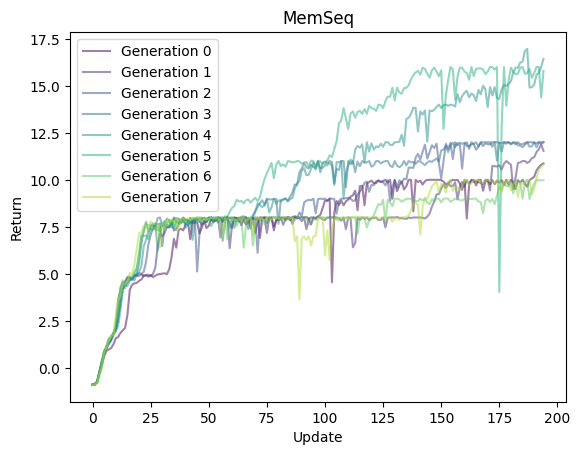

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

members = all_out_metrics
n = len(members)
colors = cm.viridis([i/n for i in range(n)])  # Use the viridis colormap

best_vals = []
for i, (m, color) in enumerate(zip(members, colors)):
    best = jnp.argmax(m[...,-1])
    best_vals.append(m[best][...,-1])
    m = m[best]
    plt.plot(m, label=f"Generation {i}", color=color, alpha=0.5)

plt.legend()
plt.ylabel("Return")
plt.xlabel("Update")
plt.title("MemSeq")
plt.show()

## IN-CONTEXT MEMORY ACCUMULATION

In [6]:
import jax
import jax.numpy as jnp
from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
import chex
from flax import struct

@struct.dataclass
class EnvState:
    timestep: int
    seq: jnp.ndarray
    trial_num: int
    trial_timestep: int
    # OTHER NETWORK IN-CONTEXT
    other_state: Optional[jnp.ndarray] = None
    other_act: Optional[jnp.ndarray] = None
    # NO NETWORK OTHERS
    other_probs: Optional[jnp.array] = None

@struct.dataclass
class EnvParams:
    # OTHER NETWORK IN-CONTEXT
    other_params: Optional[jnp.ndarray] = None
    other_init_state: Optional[jnp.ndarray] = None
    other_init_last_obs: Optional[jnp.ndarray] = None
    # OTHER MAX
    other_max_len: Optional[int] = None

class MetaMemSeq(environment.Environment):
    def __init__(
            self, 
            num_types=3,
            max_trial_len=24,
            num_trials=10,
            other_network=None,
            init_rng=None,
            num_agents=1,
            sort_best=True,
            reset_on_mistake=True,
            other_probs=None,
        ):
        super().__init__()
        self.num_types = num_types
        self.max_trial_len = max_trial_len
        self.num_trials = num_trials
        self.other_network = other_network
        self.init_rng = init_rng
        self.num_agents = num_agents
        self.sort_best = sort_best
        self.reset_on_mistake = reset_on_mistake
        self.other_probs = other_probs

    @property
    def default_params(self) -> EnvParams:
        return EnvParams()

    def step_env(
        self, key: chex.PRNGKey, state: EnvState, action: int, params: EnvParams
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        reward = jnp.where(state.seq[state.trial_timestep] == action, 1.0, -1.0)
        trial_terminated = jnp.logical_and(state.seq[state.trial_timestep] != action, self.reset_on_mistake)
        trial_terminated = jnp.logical_or(
            trial_terminated,
            state.trial_timestep == self.max_trial_len - 1,
        )

        next_trial_timestep = jnp.where(trial_terminated, 0, state.trial_timestep + 1)
        next_trial_num = jnp.where(trial_terminated, state.trial_num + 1, state.trial_num)
        terminated = jnp.logical_and(
            trial_terminated,
            next_trial_num == self.num_trials,
        ) 

        if self.other_network is None:
            key, key_other = jax.random.split(key)
            other_act_rand = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)
            other_act_gt = state.seq[next_trial_timestep][None,...]
            key, key_other_gt = jax.random.split(key)
            key_other_gts = jax.random.split(key_other_gt, self.num_agents)
            other_gt = jax.vmap(jax.random.uniform)(key_other_gts) < state.other_probs
            other_act = jnp.where(other_gt, other_act_gt, other_act_rand)
            other_state = None
        else:
            key, key_other = jax.random.split(key)
            other_state = jnp.where(trial_terminated, params.other_init_state, state.other_state)
            # other_last_act = jnp.where(trial_terminated, params.other_init_last_act, action)
            # other_reward = jnp.where(trial_terminated, params.other_init_last_reward, reward)
            other_obs = jnp.concatenate([
                jax.nn.one_hot(action, self.num_types),
                trial_terminated[None,],
                reward[None,],
                jnp.zeros(self.num_agents*self.num_types+1,),
            ], axis=-1)[None,:]
            # print(other_obs.shape)
            other_obs = jnp.tile(other_obs, (self.num_agents, 1))
            # print(other_obs.shape)
            other_obs = jnp.where(trial_terminated, params.other_init_last_obs, other_obs)

            # ac_in = [other_obs[None,None,:], jnp.zeros((1, 1))]
            ac_in = [other_obs[:,None,None,:], jnp.zeros((self.num_agents, 1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(None,0,0))(params.other_params, other_state, ac_in)
            other_act = pi.sample(seed=key_other).squeeze(1).squeeze(1)
            # other_act = jax.nn.one_hot(other_act, self.num_types)


        own_act = jax.nn.one_hot(action, self.num_types)

        new_state = EnvState(
            state.timestep + 1,
            state.seq,
            next_trial_num, 
            next_trial_timestep, 
            other_state, 
            other_act,
            state.other_probs,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < (self.num_trials - state.trial_num - 1) / (self.num_trials-1) # TODO: PLR?
        other_act = jax.nn.one_hot(other_act, self.num_types)
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act)).reshape((-1,))
        obs = jnp.concatenate([own_act, trial_terminated[None,], reward[None,], other_act, other_vis[None,]], axis=-1)
        return obs, new_state, reward, terminated, {}

    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Performs resetting of environment."""
        if self.init_rng is None:
            key, key_seq = jax.random.split(key)
            seq = jax.random.randint(key_seq, (self.max_trial_len,), 0, self.num_types)
        else:
            seq = jax.random.randint(self.init_rng, (self.max_trial_len,), 0, self.num_types)
        
        if self.other_network is None:
            if self.other_probs is not None:
                other_probs = self.other_probs
            else:
                key, key_prob = jax.random.split(key)
                key_probs = jax.random.split(key_prob, self.num_agents)
                if params.other_max_len is None:
                    print("NO MAX LEN")
                    other_probs = jax.vmap(jax.random.uniform)(key_probs) * 3 + 1
                else:
                    other_probs = jax.vmap(jax.random.uniform)(key_probs) * params.other_max_len + 1
                other_probs = 1.0 - 1.0 / other_probs
            if self.sort_best:
                other_probs = jnp.sort(other_probs)
            key, key_other = jax.random.split(key)
            other_act_rand = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)
            other_act_gt = seq[0][None,...]
            key, key_other_gt = jax.random.split(key)
            key_other_gts = jax.random.split(key_other_gt, self.num_agents)
            other_gt = jax.vmap(jax.random.uniform)(key_other_gts) < other_probs
            other_act = jnp.where(other_gt, other_act_gt, other_act_rand)
            other_state = None
        else:
            key, key_other = jax.random.split(key)
            other_obs = params.other_init_last_obs
            ac_in = [other_obs[:,None,None,:], jnp.zeros((self.num_agents, 1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(None, 0, 0))(params.other_params, params.other_init_state, ac_in)
            other_act = pi.sample(seed=key_other).squeeze(1).squeeze(1)
            other_probs = None

        state = EnvState(
            timestep=0,
            seq=seq,
            trial_num=0,
            trial_timestep=0,
            other_state=other_state,
            other_act=other_act,
            other_probs=other_probs,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < (self.num_trials - state.trial_num - 1) / (self.num_trials - 1)
        other_act = jax.nn.one_hot(other_act, self.num_types)
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act)).reshape((-1,))
        obs = jnp.concatenate([jnp.zeros(self.num_types,), jnp.zeros((2,)), other_act, other_vis[None,]], axis=-1)
        return obs, state
    
    def action_space(
        self, params: Optional[EnvParams] = None
    ) -> spaces.Discrete:
        """Action space of the environment."""
        return spaces.Discrete(self.num_types)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        return spaces.Box(jnp.zeros((self.num_types*(self.num_agents+1)+3,)), jnp.ones((self.num_types*(self.num_agents+1)+3,)), (self.num_types*(self.num_agents+1)+3,), dtype=jnp.float32)




In [21]:
num_types = 3
num_trials = 4
max_trial_len = 24
popsize = 3

def train_batch_(rng, max_len):
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 16,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 8e6,
        "UPDATE_EPOCHS": 2,
        "NUM_MINIBATCHES": 8,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.03,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ANNEAL_LR": True,
        "DEBUG": False,
        "CONTINUOUS": False,
        "UPDATE_VIS_PROB": False,
    }

    env = MetaMemSeq(
        num_types=num_types,
        num_trials=num_trials,
        max_trial_len=max_trial_len,
        num_agents=popsize,
    )

    config["ENV"] = env
    config["ENV_PARAMS"] = EnvParams(
        other_max_len=max_len,
    )
    train = make_train(config)
    out = train(rng)
    return out

max_lens = jnp.array([0.5, 1.0, 2.0])
num_seeds = 5
rng = jax.random.PRNGKey(64)
rngs = jax.random.split(rng, num_seeds)
all_outs = jax.jit(jax.vmap(jax.vmap(train_batch_, in_axes=(None, 0)), in_axes=(0, None)))(rngs, max_lens)


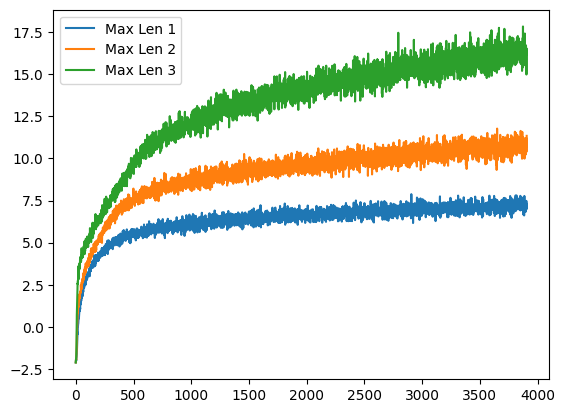

In [22]:
import matplotlib.pyplot as plt
for i in range(len(max_lens)):
    plt.plot(all_outs[1][:,i].mean(0), label=f"Max Len {i+1}")
plt.legend()
plt.show()

In [23]:
# ICL GENERAITION EVAL
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 8e6,
    "UPDATE_EPOCHS": 2,
    "NUM_MINIBATCHES": 8,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.03,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ANNEAL_LR": True,
    "DEBUG": False,
    "CONTINUOUS": False,
    "UPDATE_VIS_PROB": False,
}
num_types = 3
num_trials = 4
max_trial_len = 24
popsize = 3

init_rng = jax.random.PRNGKey(420)
init_env = MetaMemSeq(
    num_types=num_types,
    init_rng=init_rng,
    num_trials=num_trials,
    max_trial_len=max_trial_len,
    num_agents=popsize,
    other_probs=jnp.zeros((popsize,)),
)

network = ActorCriticRNN(num_types, config=config)

env = MetaMemSeq(
    num_types=num_types,
    other_network=network,
    init_rng=init_rng,
    num_trials=num_trials,
    max_trial_len=max_trial_len,
    num_agents=popsize,
)

init_env_params = EnvParams()


In [24]:
def init_eval_params_and_return(rng, params, env_params):
    rng, _rng = jax.random.split(rng)
    last_obs, env_state = init_env.reset(_rng, env_params)

    init_state = ScannedRNN.initialize_carry(1, 256)

    # COLLECT TRAJECTORIES
    def _env_step(runner_state, unused):
        prev_env_state, env_params, last_obs, last_done, prev_hstate, rng, ever_done, running_r, running_hstate, running_obs = runner_state
        rng, _rng = jax.random.split(rng)

        # SELECT ACTION
        ac_in = (last_obs[None, None, :], last_done[None, None])
        hstate, pi, value = network.apply(params, prev_hstate, ac_in)
        action = pi.sample(seed=_rng).squeeze(0).squeeze(0)

        # STEP ENV
        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = init_env.step(
            _rng, prev_env_state, action, env_params
        )

        # ONLY GET REWARDS FROM FIRST META-EPISODE
        temp_r = running_r[prev_env_state.trial_num] + (reward >= 0.0) * (1.0 - ever_done)
        running_r = running_r.at[prev_env_state.trial_num].set(temp_r)

        # ONLY FINAL HIDDEN STATE AND ACTION
        replace_hstate = jnp.logical_and((prev_env_state.trial_num == env.num_trials - 2), ~ever_done)
        running_hstate = running_hstate * (1.0 - replace_hstate) + hstate * replace_hstate
        running_obs = running_obs * (1.0 - replace_hstate) + obsv * replace_hstate

        ever_done = jnp.logical_or(done, ever_done)
        # transition = (prev_env_state, action, running_r, reward, hstate)
        transition = (env_state, action, reward, replace_hstate, running_r, running_hstate, running_obs)
        runner_state = (env_state, env_params, obsv, done, hstate, rng, ever_done, running_r, running_hstate, running_obs)
        return runner_state, transition

    runner_state = (env_state, env_params, last_obs, False, init_state, rng, False, jnp.zeros((env.num_trials,)), init_state, last_obs)
    runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, env.max_trial_len*env.num_trials+1)
    return traj_batch

def eval_params_and_return(rng, params, env_params):
    rng, _rng = jax.random.split(rng)
    last_obs, env_state = env.reset(_rng, env_params)

    init_state = ScannedRNN.initialize_carry(1, 256)

    # COLLECT TRAJECTORIES
    def _env_step(runner_state, unused):
        prev_env_state, env_params, last_obs, last_done, prev_hstate, rng, ever_done, running_r, running_hstate, running_obs = runner_state
        rng, _rng = jax.random.split(rng)

        # SELECT ACTION
        ac_in = (last_obs[None, None, :], last_done[None, None])
        hstate, pi, value = network.apply(params, prev_hstate, ac_in)
        action = pi.sample(seed=_rng).squeeze(0).squeeze(0)

        # STEP ENV
        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(
            _rng, prev_env_state, action, env_params
        )

        # ONLY GET REWARDS FROM FIRST META-EPISODE
        temp_r = running_r[prev_env_state.trial_num] + (reward >= 0.0) * (1.0 - ever_done)
        running_r = running_r.at[prev_env_state.trial_num].set(temp_r)

        # ONLY FINAL HIDDEN STATE AND ACTION
        replace_hstate = jnp.logical_and((prev_env_state.trial_num == env.num_trials - 2), ~ever_done)
        running_hstate = running_hstate * (1.0 - replace_hstate) + hstate * replace_hstate
        running_obs = running_obs * (1.0 - replace_hstate) + obsv * replace_hstate

        ever_done = jnp.logical_or(done, ever_done)
        # transition = (prev_env_state, action, running_r, reward, hstate)
        transition = (env_state, action, reward, running_r, running_hstate, running_obs)
        runner_state = (env_state, env_params, obsv, done, hstate, rng, ever_done, running_r, running_hstate, running_obs)
        return runner_state, transition

    runner_state = (env_state, env_params, last_obs, False, init_state, rng, False, jnp.zeros((env.num_trials,)), init_state, last_obs)
    runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, env.max_trial_len*env.num_trials+1)
    return traj_batch


In [25]:
test_all_trial_scores = []
for k in range(num_seeds):
    all_trial_scores = []

    for i in range(len(max_lens)):
        print(f"Seed {k}, Max Len {i+1}")

        rng = jax.random.PRNGKey(12)
        test = jax.jit(jax.vmap(init_eval_params_and_return, in_axes=(0, None, None)))
        other_params = jax.tree.map(lambda x: x[k,i], all_outs[0][0].params)
        infos = test(jax.random.split(rng, popsize), other_params, init_env_params)

        num_generations = 8
        trial_scores = []
        for j in range(num_generations):
            # 新方法：对每个agent的4个trials按分数排序（从差到好）
            trial_scores_per_agent = infos[-3][:,-1,:]  # shape: (popsize, num_trials)
            # 选择表现最好的agent
            best_agent_idx = jnp.argmax(trial_scores_per_agent.mean(axis=1))
            # 对该agent的4个trials按分数排序
            sorted_trial_indices = jnp.argsort(trial_scores_per_agent[best_agent_idx])  # 从小到大
            # 重新排列：trial 0=最差，trial 1=次差，trial 2=次优，trial 3=最好
            saved_scores = trial_scores_per_agent[best_agent_idx][sorted_trial_indices]
            saved_states = infos[-2][best_agent_idx,-1,:][sorted_trial_indices][None,:].repeat(popsize, axis=0)
            saved_obs = infos[-1][best_agent_idx,-1,:][sorted_trial_indices][None,:].repeat(popsize, axis=0)
            trial_scores.append(saved_scores.mean(0))
            print(saved_scores.mean(0))

            env_params = EnvParams(
                other_params=other_params,
                other_init_state=saved_states,
                other_init_last_obs=saved_obs,
            )

            rng = jax.random.PRNGKey(3)
            test = jax.jit(jax.vmap(eval_params_and_return, in_axes=(0, None, None)))
            infos = test(jax.random.split(rng, popsize), other_params, env_params)

        trial_scores.append(saved_scores.mean(0))
        all_trial_scores.append(np.array(trial_scores))
    test_all_trial_scores.append(np.array(all_trial_scores))


Seed 0, Max Len 1
[0.        1.        1.3333334 2.3333335]
[3.6666667 3.6666667 4.666667  6.3333335]
[6.3333335 7.        7.3333335 7.666667 ]
[8.333334 8.333334 9.       8.666667]
[10.         8.         9.333334   6.3333335]
[9.333334 8.666667 8.333334 9.      ]
[9.       8.       8.       8.666667]
[10.        8.        9.333334  6.666667]
Seed 0, Max Len 2
[0.        1.        1.3333334 2.       ]
[4.3333335 5.666667  6.        7.666667 ]
[7.3333335 8.        8.        8.666667 ]
[10.        9.333334 10.       10.333334]
[10.       10.333334 10.       10.      ]
[10.       10.        9.333334  8.666667]
[10.       10.333334  8.666667  8.666667]
[10. 10. 10. 10.]
Seed 0, Max Len 3
[0.        1.        1.3333334 2.6666667]
[4.3333335 6.3333335 6.666667  7.666667 ]
[8.333334 8.666667 8.333334 9.666667]
[10.        9.333334  9.333334  9.666667]
[ 8.666667 10.       10.333334 10.      ]
[10.       10.       10.        9.666667]
[10.       10.       10.333334 10.      ]
[10.       10.  

## RL^2 BASELINE

In [26]:
import jax
import jax.numpy as jnp
from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
import chex
from flax import struct

@struct.dataclass
class EnvState:
    timestep: int
    seq: jnp.ndarray
    trial_num: int
    trial_timestep: int
    # OTHER NETWORK IN-CONTEXT
    other_state: Optional[jnp.ndarray] = None
    other_act: Optional[jnp.ndarray] = None
    # NO NETWORK OTHERS
    other_probs: Optional[jnp.array] = None

@struct.dataclass
class EnvParams:
    # OTHER NETWORK IN-CONTEXT
    other_params: Optional[jnp.ndarray] = None
    other_init_state: Optional[jnp.ndarray] = None
    other_init_last_obs: Optional[jnp.ndarray] = None
    # OTHER MAX
    other_max_len: Optional[int] = None

class MetaMemSeq(environment.Environment):
    def __init__(
            self, 
            num_types=3,
            max_trial_len=24,
            num_trials=10,
            other_network=None,
            init_rng=None,
            num_agents=1,
            sort_best=True,
            reset_on_mistake=True,
            other_probs=None,
        ):
        super().__init__()
        self.num_types = num_types
        self.max_trial_len = max_trial_len
        self.num_trials = num_trials
        self.other_network = other_network
        self.init_rng = init_rng
        self.num_agents = num_agents
        self.sort_best = sort_best
        self.reset_on_mistake = reset_on_mistake
        self.other_probs = other_probs

    @property
    def default_params(self) -> EnvParams:
        return EnvParams()

    def step_env(
        self, key: chex.PRNGKey, state: EnvState, action: int, params: EnvParams
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        reward = jnp.where(state.seq[state.trial_timestep] == action, 1.0, -1.0)
        trial_terminated = jnp.logical_and(state.seq[state.trial_timestep] != action, self.reset_on_mistake)
        trial_terminated = jnp.logical_or(
            trial_terminated,
            state.trial_timestep == self.max_trial_len - 1,
        )

        next_trial_timestep = jnp.where(trial_terminated, 0, state.trial_timestep + 1)
        next_trial_num = jnp.where(trial_terminated, state.trial_num + 1, state.trial_num)
        terminated = jnp.logical_and(
            trial_terminated,
            next_trial_num == self.num_trials,
        ) 

        if self.other_network is None:
            key, key_other = jax.random.split(key)
            other_act_rand = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)
            other_act_gt = state.seq[next_trial_timestep][None,...]
            key, key_other_gt = jax.random.split(key)
            key_other_gts = jax.random.split(key_other_gt, self.num_agents)
            other_gt = jax.vmap(jax.random.uniform)(key_other_gts) < state.other_probs
            other_act = jnp.where(other_gt, other_act_gt, other_act_rand)
            other_state = None
        else:
            key, key_other = jax.random.split(key)
            other_state = jnp.where(trial_terminated, params.other_init_state, state.other_state)
            other_obs = jnp.concatenate([
                jax.nn.one_hot(action, self.num_types),
                trial_terminated[None,],
                reward[None,],
                jnp.zeros(self.num_agents*self.num_types+1,),
            ], axis=-1)[None,:]
            other_obs = jnp.tile(other_obs, (self.num_agents, 1))
            other_obs = jnp.where(trial_terminated, params.other_init_last_obs, other_obs)

            ac_in = [other_obs[:,None,None,:], jnp.zeros((self.num_agents, 1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(None,0,0))(params.other_params, other_state, ac_in)
            other_act = pi.sample(seed=key_other).squeeze(1).squeeze(1)


        own_act = jax.nn.one_hot(action, self.num_types)

        new_state = EnvState(
            state.timestep + 1,
            state.seq,
            next_trial_num, 
            next_trial_timestep, 
            other_state, 
            other_act,
            state.other_probs,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < (self.num_trials - state.trial_num - 1) / (self.num_trials-1) # TODO: PLR?
        other_act = jax.nn.one_hot(other_act, self.num_types)
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act)).reshape((-1,))
        obs = jnp.concatenate([own_act, trial_terminated[None,], reward[None,], other_act, other_vis[None,]], axis=-1)
        return obs, new_state, reward, terminated, {}

    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Performs resetting of environment."""
        if self.init_rng is None:
            key, key_seq = jax.random.split(key)
            seq = jax.random.randint(key_seq, (self.max_trial_len,), 0, self.num_types)
        else:
            seq = jax.random.randint(self.init_rng, (self.max_trial_len,), 0, self.num_types)
        
        if self.other_network is None:
            if self.other_probs is not None:
                other_probs = self.other_probs
            else:
                key, key_prob = jax.random.split(key)
                key_probs = jax.random.split(key_prob, self.num_agents)
                if params.other_max_len is None:
                    print("NO MAX LEN")
                    other_probs = jax.vmap(jax.random.uniform)(key_probs) * 3 + 1
                else:
                    other_probs = jax.vmap(jax.random.uniform)(key_probs) * params.other_max_len + 1
                other_probs = 1.0 - 1.0 / other_probs
            if self.sort_best:
                other_probs = jnp.sort(other_probs)
            key, key_other = jax.random.split(key)
            other_act_rand = jax.random.randint(key_other, (self.num_agents,), 0, self.num_types)
            other_act_gt = seq[0][None,...]
            key, key_other_gt = jax.random.split(key)
            key_other_gts = jax.random.split(key_other_gt, self.num_agents)
            other_gt = jax.vmap(jax.random.uniform)(key_other_gts) < other_probs
            other_act = jnp.where(other_gt, other_act_gt, other_act_rand)
            other_state = None
        else:
            key, key_other = jax.random.split(key)
            other_obs = params.other_init_last_obs
            ac_in = [other_obs[:,None,None,:], jnp.zeros((self.num_agents, 1, 1))]
            other_state, pi, value = jax.vmap(self.other_network.apply, in_axes=(None, 0, 0))(params.other_params, params.other_init_state, ac_in)
            other_act = pi.sample(seed=key_other).squeeze(1).squeeze(1)
            other_probs = None

        state = EnvState(
            timestep=0,
            seq=seq,
            trial_num=0,
            trial_timestep=0,
            other_state=other_state,
            other_act=other_act,
            other_probs=other_probs,
        )

        key, vis_key = jax.random.split(key)
        other_vis = jax.random.uniform(vis_key) < (self.num_trials - state.trial_num - 1) / (self.num_trials - 1)
        other_act = jax.nn.one_hot(other_act, self.num_types)
        other_act = jnp.where(other_vis, other_act, jnp.zeros_like(other_act)).reshape((-1,))
        obs = jnp.concatenate([jnp.zeros(self.num_types,), jnp.zeros((2,)), other_act, other_vis[None,]], axis=-1)
        return obs, state
    
    def action_space(
        self, params: Optional[EnvParams] = None
    ) -> spaces.Discrete:
        """Action space of the environment."""
        return spaces.Discrete(self.num_types)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        return spaces.Box(jnp.zeros((self.num_types*(self.num_agents+1)+3,)), jnp.ones((self.num_types*(self.num_agents+1)+3,)), (self.num_types*(self.num_agents+1)+3,), dtype=jnp.float32)



In [27]:
# SHORT SEQUENCE

config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 8e6,
    "UPDATE_EPOCHS": 2,
    "NUM_MINIBATCHES": 8,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.03,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ANNEAL_LR": True,
    "DEBUG": False,
    "CONTINUOUS": False,
    "UPDATE_VIS_PROB": False,
}

num_types = 3
num_trials = 4
max_trial_len = 24

env = MetaMemSeq(
    num_types=num_types,
    num_trials=num_trials,
    max_trial_len=max_trial_len,
)

config["ENV"] = env
config["ENV_PARAMS"] = EnvParams()

jit_train = jax.jit(jax.vmap(make_train(config)))
rng = jax.random.PRNGKey(64)
rngs = jax.random.split(rng, num_seeds)

outs_short = jit_train(rngs)


NO MAX LEN
NO MAX LEN


In [28]:
# LONG SEQUENCE

config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    # "TOTAL_TIMESTEPS": 1e6,
    "TOTAL_TIMESTEPS": 8e6,
    "UPDATE_EPOCHS": 2,
    "NUM_MINIBATCHES": 8,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.03,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ANNEAL_LR": True,
    "DEBUG": False,
    "CONTINUOUS": False,
    "UPDATE_VIS_PROB": False,
}

num_types = 3
num_trials = 32
max_trial_len = 24

env = MetaMemSeq(
    num_types=num_types,
    num_trials=num_trials,
    max_trial_len=max_trial_len,
)

config["ENV"] = env
config["ENV_PARAMS"] = EnvParams()

jit_train = jax.jit(jax.vmap(make_train(config)))
rng = jax.random.PRNGKey(64)
rngs = jax.random.split(rng, num_seeds)

outs_long = jit_train(rngs)


NO MAX LEN
NO MAX LEN


In [29]:
def init_eval_params_and_return(rng, params, env_params):
    rng, _rng = jax.random.split(rng)
    last_obs, env_state = init_env.reset(_rng, env_params)

    init_state = ScannedRNN.initialize_carry(1, 256)

    # COLLECT TRAJECTORIES
    def _env_step(runner_state, unused):
        prev_env_state, env_params, last_obs, last_done, prev_hstate, rng, ever_done, running_r, running_hstate, running_obs = runner_state
        rng, _rng = jax.random.split(rng)

        # SELECT ACTION
        ac_in = (last_obs[None, None, :], last_done[None, None])
        hstate, pi, value = network.apply(params, prev_hstate, ac_in)
        action = pi.sample(seed=_rng).squeeze(0).squeeze(0)

        # STEP ENV
        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = init_env.step(
            _rng, prev_env_state, action, env_params
        )

        # ONLY GET REWARDS FROM FIRST META-EPISODE
        temp_r = running_r[prev_env_state.trial_num] + (reward >= 0.0) * (1.0 - ever_done)
        running_r = running_r.at[prev_env_state.trial_num].set(temp_r)

        # ONLY FINAL HIDDEN STATE AND ACTION
        replace_hstate = jnp.logical_and((prev_env_state.trial_num == env.num_trials - 2), ~ever_done)
        running_hstate = running_hstate * (1.0 - replace_hstate) + hstate * replace_hstate
        running_obs = running_obs * (1.0 - replace_hstate) + obsv * replace_hstate

        ever_done = jnp.logical_or(done, ever_done)
        # transition = (prev_env_state, action, running_r, reward, hstate)
        transition = (env_state, action, reward, replace_hstate, running_r, running_hstate, running_obs)
        runner_state = (env_state, env_params, obsv, done, hstate, rng, ever_done, running_r, running_hstate, running_obs)
        return runner_state, transition

    runner_state = (env_state, env_params, last_obs, False, init_state, rng, False, jnp.zeros((env.num_trials,)), init_state, last_obs)
    runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, env.max_trial_len*env.num_trials+1)
    return traj_batch


NO MAX LEN
NO MAX LEN


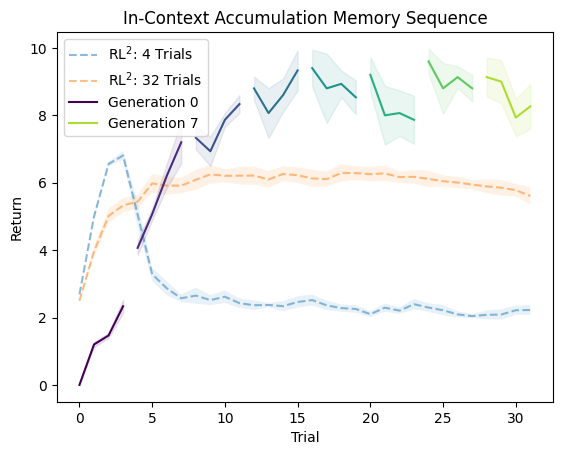

In [31]:
rng = jax.random.PRNGKey(12)
rng, rng_init = jax.random.split(rng)
env_params = EnvParams()
init_env = MetaMemSeq(
    num_types=num_types,
    num_trials=32,
    max_trial_len=max_trial_len,
)
rngs = jax.random.split(rng, 128)

test_short = jax.jit(jax.vmap(jax.vmap(init_eval_params_and_return, in_axes=(0, None, None)), in_axes=(None, 0, None)))(rngs, outs_short[0][0].params, env_params)
test_long = jax.jit(jax.vmap(jax.vmap(init_eval_params_and_return, in_axes=(0, None, None)), in_axes=(None, 0, None)))(rngs, outs_long[0][0].params, env_params)

short = test_short[-3][:, :,-1,:].mean(1)
long = test_long[-3][:, :,-1,:].mean(1)

short_mean = short.mean(0)
long_mean = long.mean(0)

short_err = short.std(0) / jnp.sqrt(num_seeds)
long_err = long.std(0) / jnp.sqrt(num_seeds)

plt.plot(short_mean, label=f"RL$^2$: 4 Trials", alpha=0.5, linestyle='dashed')
plt.fill_between(jnp.arange(32), short_mean - short_err, short_mean + short_err, alpha=0.1)
plt.plot(long_mean, label=f"RL$^2$: 32 Trials", alpha=0.5, linestyle='dashed')
plt.fill_between(jnp.arange(32), long_mean - long_err, long_mean + long_err, alpha=0.1)

k = 1
scores = np.array(test_all_trial_scores)[:,k]
scores = scores.swapaxes(0,1)

colors = cm.viridis([j/num_generations for j in range(num_generations)])  # Use the viridis colormap

for i, (m, color) in enumerate(zip(scores, colors)):
    mean = m.mean(0)
    stderr = m.std(0) / jnp.sqrt(5)
    if i == 0 or i == 7:
        plt.plot(jnp.arange(i*4,i*4+4), mean, label=f"Generation {i}", color=color, alpha=1.0)
    else:
        plt.plot(jnp.arange(i*4,i*4+4), mean, color=color, alpha=1.0)
    plt.fill_between(jnp.arange(i * 4, i * 4 + 4), mean - stderr, mean + stderr, alpha=0.1, color=color)



plt.legend()
plt.xlabel("Trial")
plt.ylabel("Return")
plt.title("In-Context Accumulation Memory Sequence")
plt.show()

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

for j, k in enumerate([0, 2, 6]):
    scores = merged_all_trial_scores[:,k]
    colors = ["blue", "orange", "green"]
    scores = scores.swapaxes(0,1)
    for i, m in enumerate(scores):
        mean = m.mean(0)
        stderr = m.std(0) / jnp.sqrt(5)
        if i == 0:
            plt.plot(jnp.arange(i*4,i*4+4), mean, label=f"Noisy Oracle Prob: {oracle_probs[k]:.2f}", alpha=1.0, color=colors[j])
        else:
            plt.plot(jnp.arange(i*4,i*4+4), mean, alpha=1.0, color=colors[j])
        plt.fill_between(jnp.arange(i * 4, i * 4 + 4), mean - stderr, mean + stderr, alpha=0.1, color=colors[j])


plt.legend()
plt.ylabel("Return")
plt.xlabel("Trial")
plt.title("In-Context Accumulation Memory Sequence")
plt.show()

NameError: name 'merged_all_trial_scores' is not defined